## IQPE

Iterative Quantum Phase Estimation

The iterative quantum phase estimation (IQPE, also known as IPEA) algorithm is a quantum 
algorithm for estimating the phase (or eigenvalue) of an eigenvector of a unitary 
operator [1, 2]. One of the main applications of the algorithm is to estimate eigenvalues (energies) 
of some molecule's Hamiltonian  $H$. 
Because $H$ is a Hermitian operator, not unitary, (the algorithm works only with unitary operators) we can't estimate directly its eigenvalues. 

Instead, we create some unitary operator from $H$ and estimate not the eigenvalues of $H$ , but something different (the phase). From the estimated phase one can obtain the corresponding eigenvalue of $H$.
So, in the end, we are not only estimating the phase but, what is more important, the desired eigenvalue. Here are the main steps of the algorithm:

### Create unitary operator $U$ from given $H$:

$$U=\exp(iHt)$$

$t$ is a parameter

### Apply $U$ on the eignestate $|\psi_k\rangle$ of $H$. 

For simplicity, we will assume that the eigenvalue is given:

$$U|\psi_k\rangle=\exp(iHt)|\psi_k\rangle$$

From the Taylor series for exponent we have:

$$ \exp(iHt)|\psi_k\rangle=itH|\psi_k\rangle -\frac{t^2}{2}H^2|\psi_k\rangle + \frac{t^4}{4}H^4|\psi_k\rangle -\cdots$$

And by using the Schrodinger equation $H|\psi_k\rangle = E_k|\psi_k\rangle$, we will obtain:

$$\exp(iHt)|\psi_k\rangle = \exp(iE_kt)|\psi_k\rangle$$

where, $E_k$ is the eigenvalue of the corresponding $|\psi_k\rangle$ eigenstate.
The goal of the algorithm is to find $E_k$.

### Estimate $E_k$ from phase

$$\exp(iHt)|\psi_k\rangle = \exp(iE_kt)|\psi_k\rangle=\exp(i2\pi\phi_k)|\psi_k\rangle$$

where $\phi_k = E_kt/2\pi$ is the phase that the algorithm is capable to estimate.
After estimating the phase it will be easy to estimate the corresponding eigenvalue:

$$E_k=\frac{2\pi\phi_k}{t}$$

## Implementation

In [1]:
import numpy as np
from random import random
from qiskit import *

In [2]:
backend = BasicAer.get_backend('qasm_simulator')
q = QuantumRegister(1)
a = QuantumRegister(1)
c = ClassicalRegister(1)

In [3]:
E_1, E_2 = (2 * np.pi * random(), 2 * np.pi * random())
print("We are going to estimate E_2 via IQPE algorithm \nE_2 = {}".format(E_2))

We are going to estimate E_2 via IQPE algorithm 
E_2 = 6.224575985827047


In [4]:
# circuit for unitary operator exp(iHt)
t = 1
unitary = QuantumCircuit(q)

unitary.p(E_2 * t, q[0]) # q[0] is the only qubit in q register
unitary.x(q[0])
unitary.p(E_1 * t, q[0])
unitary.x(q[0])

where 

$$p(\lambda)= \left(
\begin{matrix} 
1 & 0 \\ 
0 & e^{i\lambda} 
\end{matrix} 
\right),\ \ \ \ \ X= \left(
\begin{matrix} 
0 & 1 \\ 
1 & 0 
\end{matrix} 
\right) $$

In [5]:
unitary.draw()

┌───────────┐┌───┐┌───────────┐┌───┐
q0: ┤ P(6.2246) ├┤ X ├┤ P(2.6126) ├┤ X ├
    └───────────┘└───┘└───────────┘└───┘

The above unitary circuit means one qubit quantum state $\psi$

$$ e^{iHt}|\psi\rangle = c_1 e^{iE_1 t}|0\rangle + c_2 e^{iE_2t}|1\rangle $$

In [6]:
# create the circuit for the  control version of the exp(iHt) unitary
control_u = unitary.to_gate().control()

In [7]:
k_circ = QuantumCircuit(a, q, c)
k_circ.x(q[0])
k_circ.h(a[0])
k_circ.append(control_u,[0,1])
k_circ.p(-np.pi,a[0])
k_circ.h(a[0])
k_circ.measure(a[0],c[0])

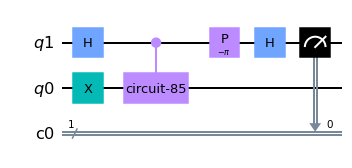

In [8]:
k_circ.draw('mpl')

In [31]:
num_bits_estimate = 10
phase = 0
for k_precision in reversed(range(num_bits_estimate)):
    # Create a Quantum Circuit acting on the q register
    k_circ = QuantumCircuit(a, q, c)

    # (1) |1> eigenstate initialization
    k_circ.x(q[0])

    # (2) Initial Hadamard gate applied on ancillary qubit.
    k_circ.h(a[0])

    # (3) The control Hamiltonian applied on the qubits where control qubit is the ancillary qubit.
    for order in range(2 ** k_precision):
        k_circ.append(control_u,[0,1])

    # (4) The phase gate and final Hadamard gate on ancillary qubit.
    phase_shift = 2 * np.pi * phase * 2 ** k_precision
    k_circ.p(-phase_shift, a[0])
    k_circ.h(a[0])

    # (5) Measurement of ancillary qubit (findig the bit)
    k_circ.measure(a[0], c[0])

    # (6) executing on Quantum Computer and finding a bit from the phase
    job = execute(k_circ, backend, shots=10000)
    result = job.result()
    counts = result.get_counts()
    value = int(max(counts, key=counts.get))

    # (7) phase after this iteration
    phase += value / 2 ** (k_precision + 1)

In [32]:
eigenvalue = 2 * np.pi * phase / t
print("Eigenvalue of the Hamiltonian: {}".format(E_2))
print("Estimated eigenvalue of the Hamiltonian: {}".format(eigenvalue))

Eigenvalue of the Hamiltonian: 6.224575985827047
Estimated eigenvalue of the Hamiltonian: 6.22182607566416
